In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import io
import os
import subprocess
import sys

import pandas as pd
from Bio import Entrez, Phylo, SearchIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pynucl.hist_features import hist_features, hist_shf4seq
from pytexshade import ipyshade, shade

In [4]:
def show_msa_jl(msa):
    """
    This requires jupyterlab-fasta extenstion and works only in jupyterlab
    """
    data = msa.format("fasta")
    bundle = {}
    bundle["application/vnd.fasta.fasta"] = data
    bundle["text/plain"] = data
    display(bundle, raw=True)

In [5]:
def muscle_aln(sequences, options=[], debug=False):
    muscle = os.path.join(os.path.dirname(sys.executable), "muscle")
    process = subprocess.Popen(
        [muscle] + options,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    aln, error = process.communicate(sequences.encode("utf-8"))
    if debug:
        print(sequences)
        print()
        print("Stderr:")
        print(error.decode("utf-8"))
        print("Stdout:")
        print(aln.decode("utf-8"))
    seqFile = io.StringIO()
    seqFile.write(aln.decode("utf-8"))
    seqFile.seek(0)
    sequences_ids = [s.split(" ", 1)[0] for s in sequences.split(">")]
    sequences = list(
        SeqIO.parse(seqFile, "fasta")
    )  # Not in same order, but does it matter?
    sequences.sort(key=lambda x: sequences_ids.index(x.id))  # Yes, it matters
    msa = MultipleSeqAlignment(sequences)
    return msa

In [6]:
def cons_features(msa):
    features_shf4seq = hist_shf4seq(
        SummaryInfo(msa).dumb_consensus(threshold=0.1, ambiguous="X")
    )
    features = []
    for f in features_shf4seq:
        f_new = f
        f_new["seqref"] = "consensus"
        features.append(f_new)
    return features

In [42]:
species = ["Chimpanzee", "Macaque", "Cat", "Cattle", "Dog", "Horse", "Pig"]

In [43]:
df = pd.DataFrame()
for sp in species:
    df_sp = pd.read_csv(
        f"{sp}_genes_vgnc.csv",
        dtype={
            "ncbi_id": "Int64",
        },
    )
    df_sp = df_sp[df_sp["Histone variant"].str.startswith("clustered", na=False)]
    print(f"{sp} shape: {df_sp.shape}")
    df = pd.concat([df, df_sp])
df.head()

Chimpanzee shape: (73, 18)
Macaque shape: (66, 18)
Cat shape: (68, 19)
Cattle shape: (67, 18)
Dog shape: (164, 19)
Horse shape: (75, 19)
Pig shape: (55, 19)


,Histone type,Histone variant,Clustered (canonical) isoform,vgnc_id,symbol,name,prev_symbol,prev_name,ncbi_id,ensembl_gene_id,uniprot_ids,Human gene ortholog HGNC ID,refseq_id,accession,sequence,sequence_length,Species,taxon_id,comment
17,H2A,clustered H2A,isoform_1,VGNC:14358,H2AC1,H2A clustered histone 1,HIST1H2AA,histone cluster 1 H2A family member a,462486,ENSPTRG00000017789,A0A5S6R7Q6|H2QSE5,HGNC:18729,XP_518282.1,XP_518282.1,MSGRGKQGGKARAKSKSRSSRAGLQFPVGRIHRLLRKGNYAERIGA...,131.0,Chimpanzee,9598,NaN
18,H2A,clustered H2A,isoform_5,VGNC:83647,H2AC10,H2A clustered histone 10,NaN,NaN,471887,NaN,NaN,HGNC:4732,XP_527265.2,XP_527265.2,MQGSKARAKAKKHSSRAGLQFSVGRMHRLLRKGNYAKPVRAGAPVY...,115.0,Chimpanzee,9598,NaN
19,H2A,clustered H2A,isoform_6,VGNC:83651,H2AC11,H2A clustered histone 11,NaN,NaN,471894,NaN,NaN,HGNC:4737,XP_063668326.1,XP_063668326.1,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,130.0,Chimpanzee,9598,NaN
20,H2A,clustered H2A,isoform_8,VGNC:83655,H2AC12,H2A clustered histone 12,NaN,NaN,471895,NaN,NaN,HGNC:13671,XP_063668327.1,XP_063668327.1,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,128.0,Chimpanzee,9598,NaN
21,H2A,clustered H2A,isoform_6,VGNC:83654,H2AC13,H2A clustered histone 13,NaN,NaN,462506,NaN,NaN,HGNC:4725,XP_054542623.1,XP_054542623.1,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,130.0,Chimpanzee,9598,NaN


In [44]:
df_gr = df.groupby(by=["Species", "Histone type"])

# H2A Cat

In [45]:
df_gr.get_group(("Dog", "H2A"))[
    ["Clustered (canonical) isoform", "sequence"]
].drop_duplicates()

,Clustered (canonical) isoform,sequence
38,isoform_1,MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...
39,isoform_2,MSGRGKQGGKARAKAKTRSSQGRACQFPVGRVHRLLRKGNYAERVG...
40,isoform_9,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...
41,isoform_7,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGA...
44,isoform_13,MSGRGKQGGKARAKAKTRSSRAGLQFPILELAGNAARDNKKTRIIP...
45,isoform_14,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...
46,isoform_8,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...
49,isoform_15,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...
55,isoform_10,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGA...
56,isoform_11,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGA...


In [135]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['Clustered (canonical) isoform']}",
            name=f"{row['Clustered (canonical) isoform']}",
            description=f"desc",
        ).format("fasta")
        for i, row in df_gr.get_group(("Cattle", "H2A"))[
            ["Clustered (canonical) isoform", "sequence"]
        ]
        .drop_duplicates()
        .sort_values(
            by=["Clustered (canonical) isoform"] #, key=lambda col: col.str.split("_")[1]
        )
        .iterrows()
    ]
)
msa = muscle_aln(sequences)

In [136]:
print(sequences)

>isoform_1 desc
MYVNEAIRLSFADWLDGHQPIRKQSTTYRQAINRSSKFSLFLYALSPAFCKVMLGHKKQD
GKAHAKTKSRSSRAGLHFPVGRIYRLPHKGNCAERVGAGEPVYLAAVLEYLMAEILESAD
NASHDKKKTRIIPCHLQLAIHNEELNKLLGGVTIQGCVLPKIQPVLLPKKTGSHHHKVQS
K

>isoform_10 desc
MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYMAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHKAKSK

>isoform_11 desc
MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGGVTIAQGGVLPNIQAVLLPKK
TESHKPGKNK

>isoform_12 desc
MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>isoform_2 desc
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>isoform_3 desc
MSGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>isoform_4 desc
MSGRGKQGGKARAKAKSRSSRAGLQFPVGR

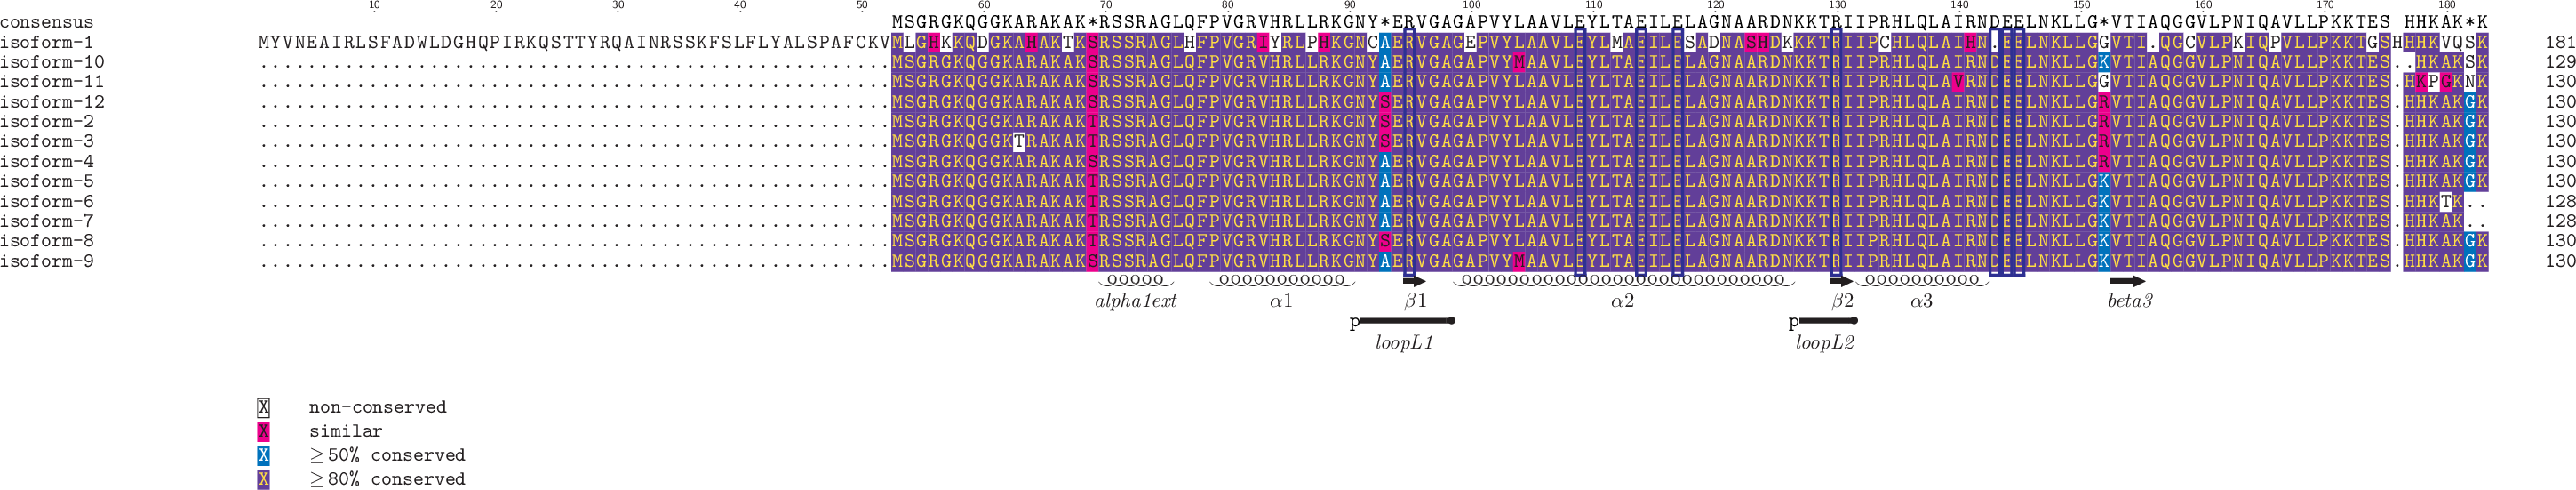

In [137]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
    features=cons_features(msa)
)

In [134]:
shade.shade_aln2png(
    msa,
    filename=f"msa_h4_pig.png",
    shading_modes=["similar"],
    # ruler=True,
    # logo=True,
    splitN=70,
)